<h1> Here we will be focusing more on the cnmf part and its main functions <h1>
<img src='docs/img/cnmf1.png'/>

In [1]:
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic(u'load_ext autoreload')
        get_ipython().magic(u'autoreload 2')
except NameError:       
    print('Not IPYTHON')    
    pass

import sys
import numpy as np
from time import time
from scipy.sparse import coo_matrix
import psutil
import glob
import os
import scipy
from ipyparallel import Client
import pylab as pl
import caiman as cm
from caiman.components_evaluation import evaluate_components
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
from caiman.base.rois import extract_binary_masks_blob
import caiman.source_extraction.cnmf as cnmf
from caiman.utils.utils import download_demo

Using TensorFlow backend.


In [2]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
try:
       from bokeh.io import vform, hplot
except:
       # newer version of bokeh does not use vform & hplot, instead uses column & row
       from bokeh.layouts import column as vform
       from bokeh.layouts import row as hplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cmap
import numpy as np

bpl.output_notebook()

Loading BokehJS ...

<h1> Using the workload manager SLURM </h1> 
to have an extensive use of the machine. 

<p> we want to operate this the faster possible. Thanks to the segmentation of the video in patches we can parallelize ou algorithm. We are using python integrated methods to get this parallelization to work on one machine as well as on clusters of machines </p>

<table> <tr> <td> This is to be used when working with a cluster of machines :  </td>
 <td>This will put dispatch and manage the workload gave by the algorithm : </td> </tr>
<tr> <td><img src="docs/img/Dockerfile.gif"/> 
<td> <img src="docs/img/node.gif" /> </td> </tr>
<p> learn more : <em> https://slurm.schedmd.com/overview.html </em> </p>

In [3]:
# frame rate in Hz
final_frate=10 
#backend='SLURM'
backend='local'
if backend == 'SLURM':
    n_processes = np.int(os.environ.get('SLURM_NPROCS'))
else:
    # roughly number of cores on your machine minus 1
    n_processes = np.maximum(np.int(psutil.cpu_count()),1) 
print('using ' + str(n_processes) + ' processes')
#%% start cluster for efficient computation
single_thread=False

if single_thread:
    dview=None
else:    
    try:
        c.close()
    except:
        print('C was not existing, creating one')
    print("Stopping  cluster to avoid unnencessary use of memory....")
    sys.stdout.flush()  
    if backend == 'SLURM':
        try:
            cm.stop_server(is_slurm=True)
        except:
            print('Nothing to stop')
        slurm_script='/mnt/xfs1/home/agiovann/SOFTWARE/Constrained_NMF/SLURM/slurmStart.sh'
        cm.start_server(slurm_script=slurm_script)
        pdir, profile = os.environ['IPPPDIR'], os.environ['IPPPROFILE']
        c = Client(ipython_dir=pdir, profile=profile)        
    else:
        cm.stop_server()
        cm.start_server()        
        c=Client()

    print('Using '+ str(len(c)) + ' processes')
    dview=c[:len(c)]

using 32 processes
C was not existing, creating one
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
b'2017-11-10 10:53:33.264 [IPClusterStop] Removing pid file: D:\\Research\\Programs\\Included\\ATLab\\.ipython\\profile_default\\pid\\ipcluster.pid\r\n'
**** Unrecognized Syntax in ipcluster output, waiting for server to stop anyways ****
 done
Starting cluster...........................................................................................................Using 32 processes


<b> We can see here that the number of processes are the number of core your computer possess. <br/> Your computer can be seen as a node that possess X cores </b>

<h1> Memory mapping files in F order</h1>
<p> see : http://localhost:8888/notebooks/CaImAn/demo_caiman_pipeline.ipynb </p>
<p> We want the parallel processes to access and our video matrix without having it in memory and duplicating it, as explained already on the demo_pipeline notebook </p>
<img src="docs/img/Fordermmap.png" /> 

In [4]:
#%% FOR LOADING ALL TIFF FILES IN A FILE AND SAVING THEM ON A SINGLE MEMORY MAPPABLE FILE
fnames=['demoMovieJ.tif']
base_folder='./example_movies/' # folder containing the demo files
# %% download movie if not there                                                                                                                                                                                
if fnames[0] in ['Sue_2x_3000_40_-46.tif','demoMovieJ.tif']:
    download_demo(fnames[0])
    fnames = [os.path.join('example_movies',fnames[0])]
m_orig = cm.load_movie_chain(fnames[:1])

File already downloaded


100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


In [5]:
downsample_factor=1 # use .2 or .1 if file is large and you want a quick answer
final_frate=final_frate*downsample_factor
name_new=cm.save_memmap_each(fnames
        , dview=dview,base_name='Yr', resize_fact=(1, 1, downsample_factor)
        , remove_init=0,idx_xy=None )
name_new.sort()
fname_new=cm.save_memmap_join(name_new,base_name='Yr', n_chunks=12, dview=dview)
print(fnames)
print(fname_new)
print ("\n we can see we are loading the file (line1) into a memorymapped object (line2)")

('example_movies\\Yr0000_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap', 2000)
example_movies\Yr_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap
Deleting big mov
['example_movies\\demoMovieJ.tif']
example_movies\Yr_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap

 we can see we are loading the file (line1) into a memorymapped object (line2)


<h2>the correlation image </h2>


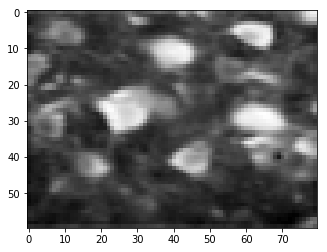

In [6]:
Yr,dims,T=cm.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
#%% visualize correlation image
Cn = cm.local_correlations(Y)
pl.imshow(Cn,cmap='gray') 
pl.show()

 CNMFSetParms define Dictionaries of CNMF parameters.
 Any parameter that is not set get a default value specified.
 
     each dictionnary is used by different part of the CNMF process : 
 - init_paramters
 - pre_processing_parameters
 - patch_parameters
 - spatial_parameters
 - temporal_parameters
    

In [7]:
K=30 # number of neurons expected per patch
gSig=[6,6] # expected half size of neurons
merge_thresh=0.8 # merging threshold, max correlation allowed
p=2 #order of the autoregressive system
options = cnmf.utilities.CNMFSetParms(Y
        ,n_processes,p=p,gSig=gSig,K=K,ssub=2,tsub=2, normalize_init=True)

<h2> Preprocessing of the datas and initialization of the components </h2>
<ul><li> here, we compute the mean of the noise spectral density </li>
<li> then, we initialize each component (components that have been spatially filter using a gaussian kernel) with a greedy algorithm </li>
<li> we then operate a rank1 NMF on those ROIs using the HALS algorithm</li></ul>
<p> see More : NMF AND ROI :http://www.cell.com/neuron/fulltext/S0896-6273(15)01084-3<br\></p>
Simultaneous Denoising, Deconvolution, and Demixing of Calcium Imaging Data by Eftychios A. Pnevmatikakis & al. 

In [8]:
Yr,sn,g,psx = cnmf.pre_processing.preprocess_data(Yr
            ,dview=dview
            ,n_pixels_per_process=100,  noise_range = [0.25,0.5]
            ,noise_method = 'logmexp', compute_g=False,  p = 2,
             lags = 5, include_noise = False, pixels = None
            ,max_num_samples_fft=3000, check_nan = True)

Ain, Cin, b_in, f_in, center=cnmf.initialization.initialize_components(Y
            ,K=30, gSig=[5, 5], gSiz=None, ssub=1, tsub=1, nIter=5, maxIter=5, nb=1
            , use_hals=False, normalize_init=True, img=None, method='greedy_roi'
            , max_iter_snmf=500, alpha_snmf=10e2, sigma_smooth_snmf=(.5, .5, .5)
            , perc_baseline_snmf=20)
p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None
                    , line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

checking if missing data
Running on 32 engines.
Noise Normalization
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING TOTAL SUM FOR INITIALIZATION....


C:\ProgramFiles\Miniconda3\envs\atpipeline\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Research\Programs\Included\ATLab\CaImAn\caiman\utils\visualization.py:914: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


<h2> HALS </h2>
we want to minimize
<img src=docs/img/hals1.png width=300px/>
updating parameters
<img src=docs/img/hals2.png width=300px />
<p>HALS :  (Keigo Kimura et al.) http://proceedings.mlr.press/v39/kimura14.pdf</p>


In [9]:
Ain, Cin, b_in, f_in = cnmf.initialization.hals(Y, Ain, Cin, b_in, f_in, maxIter=5)
p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None
                    , line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

D:\Research\Programs\Included\ATLab\CaImAn\caiman\utils\visualization.py:914: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


<h1> CNMF process </h1>

*** We are considering the video as a matrix called Y of dimension height x widht x frames ***

    we now want to find A, C and B such that Y = A x C + B
    
    B being the Background, composed of its spatial b and temporal f component
    A being the spatial component of the neurons (also seen as their shape)
    C being the temporal component of the neurons (also seen as their calcium activity or traces)



<h2> Update spatial </h2>

** will consider C as fixed and try to update A. **

    the process will be the following : 
    
   - intialization of each parameters 
   - testing of the input values
    
   - finding relevant pixels in that should belong to the neuron using either an iterative structure or an ellipse to look around the center of mass of the neuron ( cm found in the initialization )
     - this will be define a first shape of the neuron 
     - /!\ pixels are usually unlinked
            
   - computing the distance indicator (a map of the distances of each relevant pixels to the center of mass of the neuron)
   
   -  memory mapping the matrices C and Y (info before)
   
   - updating the components in parallel : 
     - using ipyparralel
     - solving this problem for each pixel of the component
          $$ arg\min_{A_i,B_i}\sum A_i $$
       subject to
          $$|| Y_i - A_i\times C + b_i\times f || <= std_{noise}(i)\times \sqrt(T)$$
     - using the lasso lars method from scikit learn toolbox
         https://en.wikipedia.org/wiki/Least-angle_regression, <br/>
         https://en.wikipedia.org/wiki/Lasso_(statistics), <br/>
         http://scikit-learn.org/stable/modules/linear_model.html#lars-lasso
   
   
   - then, the newly refined components are thresholded (the C of the CNMF, one of the constrained here is that the matrix needs to be sparse) :
   
     - first by applicating a median filtering  https://en.wikipedia.org/wiki/Median_filter
     - then by thresholding using a normalized user defined value 
     - continuing with a morphological closing of the components, using openCv functions https://www.mathworks.com/help/images/ref/imclose.html (the matlab version)
     - we remove the unconnected pixels (we keep the large connected components )
     
     
   - finnaly we compute the residuals (also called the background) which is computed as B=Y-AC
   
       
   

In [10]:
options['spatial_params']['n_pixels_per_process'] = 2000

In [ ]:
A,b,Cin,f_in = cnmf.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, dview=dview,**options['spatial_params'])

In [11]:
p1=nb_plot_contour(Cn,A.todense(),dims[0],dims[1],thr=0.9,face_color=None,
                   line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

NameError: name 'A' is not defined

<h2> Update temporal </h2>

** Will consider A as fixed and try to update C. **

    the process will be the following : 
    
   - Intialization of each parameters 
   - Testing of the input values
    
   - Generating residuals s.t. $$Yres_A = YA - (A^T AC)^T$$
   
   - Creating groups of components that can be processed in parallel
     - Ones that are composed of not overlapping components
     - Using a simple greedy method
     
   - Updating Calcium traces ( C ) 
     - Using Oasis. which will deconvolve the spikes of each neurons from the Calcium traces matrix C.  <br\><br\> learn more : (Friedrich & al) http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005423
     see the demo here : https://github.com/j-friedrich/OASIS/blob/master/examples/Demo.ipynb
       - To infer the true shape of the calcium traces using an autoregressive framework
       - To infer the most likely spike train ( also called particular events). It will find the probability of a spike train according to the mean and std of the trace. 
            - If it is superior to a threshold it will be defined as a particular event/neural spike
      
            -  This will give us a matrix which is itself constrained ( C from CNMF ) 
     - This is done in parallel using ipyparallel. 
   - We finally update the background

In [ ]:
options['temporal_params']['block_size'] = 2000

In [ ]:
options['temporal_params']['p'] = 0 # fast updating without deconvolution
C,A,b,f,S,bl,c1,neurons_sn,g,YrA,lam = cnmf.temporal.update_temporal_components(
    Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])  
clear_output(wait=True)

<h2> Merging components </h2>

**merge the components that overlaps and have a high temporal correlation **

    the process will be the following : 
    
   - intialization of each parameters 
   - testing of the input values
   
   - find a graph of overlapping components
     - we look for connected ones
     - we keep the one that are "connected enough" (above a threshold)
     
    
   - On Each groups : 
     - We normalize the components to be able to compare them
     - We sum them together
     - we process a rank one NMF
     - we compute the traces (deconvolution)
     - We replace the neurons by the merged one
   

In [ ]:
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cnmf.merging.merge_components(
    Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'],
    dview=dview, bl=bl, c1=c1, sn=neurons_sn, g=g, thr=merge_thresh,
    mx=50, fast_merge = True)

# A refining step
refine spatial and temporal components

In [ ]:
A2,b2,C2,f = cnmf.spatial.update_spatial_components(Yr, C_m, f, A_m,
                                sn=sn,dview=dview, **options['spatial_params'])
options['temporal_params']['p'] = p # set it back to perform full deconvolution

C2,A2,b2,f2,S2,bl2,c12,neurons_sn2,g21,YrA, lam = cnmf.temporal.update_temporal_components(
    Yr,A2,b2,C2,f,dview=dview, bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
clear_output(wait=True)

<h1>DISCARD LOW QUALITY COMPONENT </h1>
<p> The patch dubdivision creates several spurious components that are not neurons </p>
<p>We select the components according to criteria examining spatial and temporal components</p>
<img src="docs/img/evaluationcomponent.png"/>

<p> Temporal components, for each trace: </p>

<li>  compute the robust mode, corresponding to the baseline value</li>
<li> use the values under the mode to estimate noise variance</li>
<li> compute the probability of having large transients  given the noise distribution estimated </li>
<li> Threshold on this probability s.t. some of the component are discarded because lacking large enough positive transients </li>

<p> Spatial components, for each components: </p>

<li> average the frames in the moveie where the neurons is active (from temporal component), this provides a nice image of the neuron</li>
<li> compare this image with the corresponding spatial component (Person's correlation coefficient)</li>
<li> threshold the correlation coefficient  </li>


In [ ]:
#evaluation
fitness_raw, fitness_delta, erfc_raw,erfc_delta, r_values, significant_samples = evaluate_components(Y, C2+YrA, A2, C2, b2, f2, final_frate,
                                          remove_baseline=True,N=5, robust_std=False,
                                          Athresh=0.1, Npeaks=10,  thresh_C=0.3)
#different thresholding ( needs to pass at least one of them )
traces = C2 + YrA
idx_components_r=np.where(r_values>=.6)[0]
idx_components_raw=np.where(fitness_raw<-60)[0]        
idx_components_delta=np.where(fitness_delta<-20)[0]   

#merging to have all that have passed at least one threshold.
idx_components=np.union1d(idx_components_r,idx_components_raw)
idx_components=np.union1d(idx_components,idx_components_delta) 
#finding the bad components
idx_components_bad=np.setdiff1d(range(len(traces)),idx_components)

clear_output(wait=True)
print(' ***** ')
print(len(traces))
print(len(idx_components))

In [ ]:
fg=pl.figure(figsize=(12,20))
pl.subplot(1,2,1)
crd = plot_contours(A2.tocsc()[:,idx_components],Cn,thr=0.9)

pl.subplot(1,2,2)
crd = plot_contours(A2.tocsc()[:,idx_components_bad],Cn,thr=0.9)

In [ ]:
p2=nb_plot_contour(Cn,A2.tocsc()[:,idx_components].todense(),dims[0],dims[1],thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
bpl.show(p2)

# accepted components

In [ ]:
discard_traces_fluo=nb_view_patches(Yr,A2.tocsc()[:,idx_components],C2[idx_components],b2,f2,dims[0],dims[1],thr = 0.8,image_neurons=Cn, denoised_color='red')

# discarded components

In [ ]:
discard_traces_fluo=nb_view_patches(Yr,A2.tocsc()[:,idx_components_bad],C2[idx_components_bad],b2,f2,dims[0],dims[1],thr = 0.8,image_neurons=Cn, denoised_color='red')

In [ ]:
cm.stop_server()